In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score
import random
from wordcloud import WordCloud
#hs
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/PROJECT/Reviews.csv')
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [4]:
print(len(df))

#Removing duplicate entries based on past knowledge.
df = df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(len(df))

568454
393933


In [5]:
print(len(df))

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
df = df[df.HelpfulnessNumerator <= df.HelpfulnessDenominator]

print(len(df))

393933
393931


In [6]:
df['Score'].value_counts()

5    250961
4     56093
1     36306
3     29769
2     20802
Name: Score, dtype: int64

In [7]:
df = df[['Time', 'Text', 'Score']]

In [8]:
def fuc(x):
    if x>3:
        return 1
    elif x<3:
        return -1
    else:
        return 0

# Labels as 1 - positive (score > 3) or 0 - negative (score < 3)
df['Score2'] = df['Score'].apply(fuc)

df

,Time,Text,Score,Score2
0,1303862400,I have bought several of the Vitality canned d...,5,1
1,1346976000,Product arrived labeled as Jumbo Salted Peanut...,1,-1
2,1219017600,This is a confection that has been around a fe...,4,1
3,1307923200,If you are looking for the secret ingredient i...,2,-1
4,1350777600,Great taffy at a great price. There was a wid...,5,1
...,...,...,...,...
568449,1299628800,Great for sesame chicken..this is a good if no...,5,1
568450,1331251200,I'm disappointed with the flavor. The chocolat...,2,-1
568451,1329782400,"These stars are small, so you can give 10-15 o...",5,1
568452,1331596800,These are the BEST treats for training and rew...,5,1


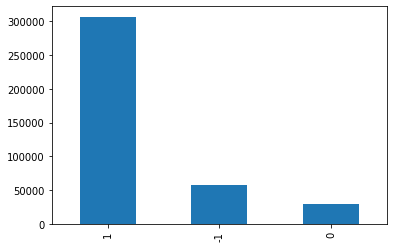

In [9]:
df['Score2'].value_counts().plot(kind='bar')


In [10]:
def removeHTML(sentence):
    regex = re.compile('<.*?>')
    return re.sub(regex, ' ', sentence)

In [11]:
def removeURL(sentence):
    regex = re.compile('http[s]?://\S+')
    return re.sub(regex, ' ', sentence)

In [12]:
def onlyAlphabets(sentence):
    regex = re.compile('[^a-zA-Z]')
    return re.sub(regex, ' ', sentence)

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop = nltk.corpus.stopwords.words('english')
stop.remove('not')
print(len(stop))

178


In [15]:

sno = nltk.stem.SnowballStemmer('english')    # Initializing stemmer


In [16]:
positive = []    # All words in positive reviews
negative = [] # All words in negative reviews
average=[]
all_sentences = []    # All cleaned sentences


for x in range(len(df['Text'].values)):
    review = df['Text'].values[x]
    rating = df['Score2'].values[x]

    cleaned_sentence = []
    sentence = removeURL(review) 
    sentence = removeHTML(sentence)
    sentence = onlyAlphabets(sentence) 
    sentence = sentence.lower()    

    for word in sentence.split():
        if word not in stop:
            stemmed = sno.stem(word)
            cleaned_sentence.append(stemmed)
            
            if rating == 1 :
                positive.append(stemmed)
            elif rating==-1:
                negative.append(stemmed)
            else:
                average.append(stemmed)

    all_sentences.append(' '.join(cleaned_sentence))

# add as column in dataframe
df['Cleaned'] = all_sentences

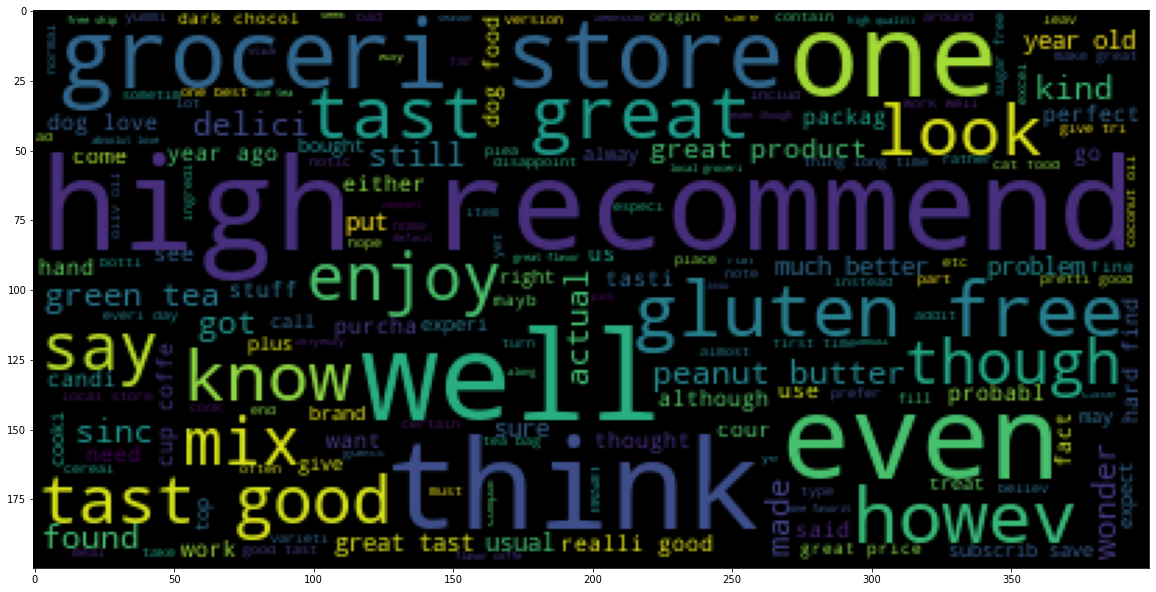

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(' '.join(positive)))

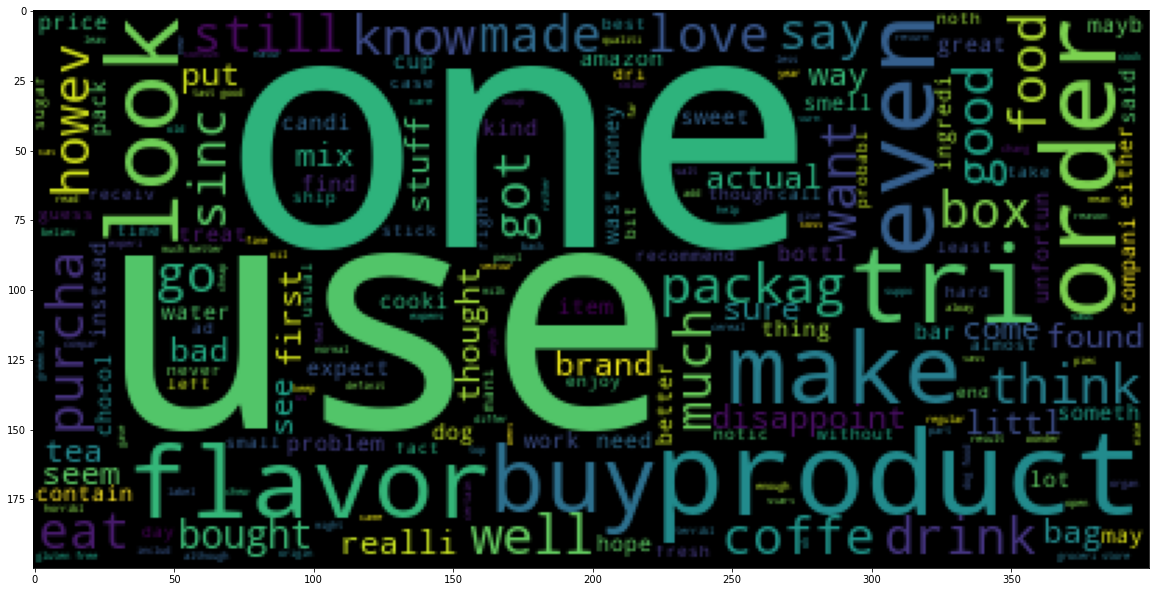

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(' '.join(negative)))


In [19]:
df[df['Cleaned'].isna()]

,Time,Text,Score,Score2,Cleaned


In [20]:
df = df.dropna()

df

,Time,Text,Score,Score2,Cleaned
0,1303862400,I have bought several of the Vitality canned d...,5,1,bought sever vital can dog food product found ...
1,1346976000,Product arrived labeled as Jumbo Salted Peanut...,1,-1,product arriv label jumbo salt peanut peanut a...
2,1219017600,This is a confection that has been around a fe...,4,1,confect around centuri light pillowi citrus ge...
3,1307923200,If you are looking for the secret ingredient i...,2,-1,look secret ingredi robitussin believ found go...
4,1350777600,Great taffy at a great price. There was a wid...,5,1,great taffi great price wide assort yummi taff...
...,...,...,...,...,...
568449,1299628800,Great for sesame chicken..this is a good if no...,5,1,great sesam chicken good not better restur eat...
568450,1331251200,I'm disappointed with the flavor. The chocolat...,2,-1,disappoint flavor chocol note especi weak milk...
568451,1329782400,"These stars are small, so you can give 10-15 o...",5,1,star small give one train session tri train do...
568452,1331596800,These are the BEST treats for training and rew...,5,1,best treat train reward dog good groom lower c...


In [21]:
df = df.sort_values('Time')

split = int(0.8*len(df))

# The latest reviews are used in the test set.
Xtrain, Xtest = df['Cleaned'][:split], df['Cleaned'][split:]
ytrain, ytest = df['Score2'][:split], df['Score2'][split:]

print("Train set - ", Xtrain.shape[0])
print("Test set - ", Xtest.shape[0])


Train set -  315144
Test set -  78787


In [22]:
bow = CountVectorizer()
Xtrain = bow.fit_transform(Xtrain)
Xtest = bow.transform(Xtest)

Xtrain.shape, Xtest.shape

((315144, 66590), (78787, 66590))

In [23]:
scalar = StandardScaler(with_mean=False)

scalar.fit(Xtrain)
Xtrain = scalar.transform(Xtrain)
Xtest = scalar.transform(Xtest)

In [24]:
ytest = np.array(list(ytest))

In [25]:
ytrain=np.array(list(ytrain))

In [26]:
X = []
sentences = list(df['Cleaned'])
for sen in sentences:
    X.append(sen)

In [27]:
print(df['Score2'].unique())

[ 1 -1  0]


In [28]:
y = df['Score2']
y = np.array(list(map(lambda x: 1 if x==1 else 0,y)))


In [29]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
#by using NN

In [32]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/PROJECT/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [33]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [34]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [35]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [36]:
from keras.layers.recurrent import LSTM

In [37]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [38]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          6705700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 6,823,077
Trainable params: 117,377
Non-trainable params: 6,705,700
_________________________________________________________________
None


In [39]:
history = model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
1970/1970 [==============================] - 703s 355ms/step - loss: 0.5215 - acc: 0.7797 - val_loss: 0.3657 - val_acc: 0.8397
Epoch 2/3
1970/1970 [==============================] - 694s 352ms/step - loss: 0.3478 - acc: 0.8487 - val_loss: 0.3173 - val_acc: 0.8660
Epoch 3/3
2463/2463 [==============================] - 85s 35ms/step - loss: 0.2899 - acc: 0.8766


In [40]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2899375855922699
Test Accuracy: 0.876642107963562


In [41]:
import matplotlib.pyplot as plt 

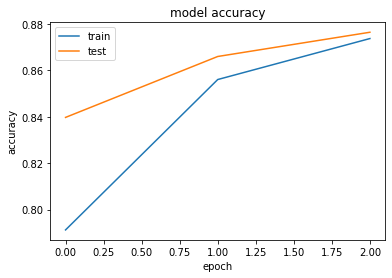

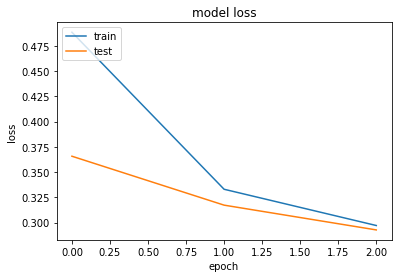

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [43]:
pip install SpeechRecognition

In [44]:
import speech_recognition as sr
r = sr.Recognizer()

In [45]:
#HATESPEECH

In [46]:
f2=pd.read_csv('/content/drive/My Drive/PROJECT/mm_hs.csv')

In [47]:
nr,nc=f2.shape
print(f'{nr} rows and {nc} columns')

24783 rows and 7 columns


In [48]:
f2

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [49]:
c1=f2['class']
f2.rename(columns={'tweet' : 'text','class' : 'category'},inplace=True)
a1=f2['text']
b1=f2['category'].map({0: 'hatespeech', 1: 'offensivelanguage',2: 'none of these'})
f2= pd.concat([a1,b1,c1], axis=1)
f2.rename(columns={'category' : 'label'},inplace=True)
f2

,text,label,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,none of these,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensivelanguage,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensivelanguage,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensivelanguage,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensivelanguage,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensivelanguage,1
24779,"you've gone and broke the wrong heart baby, an...",none of these,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensivelanguage,1
24781,youu got wild bitches tellin you lies,offensivelanguage,1


In [50]:
f2['text_length'] = f2['text'].apply(len)
f2


,text,label,class,text_length
0,!!! RT @mayasolovely: As a woman you shouldn't...,none of these,2,140
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensivelanguage,1,85
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensivelanguage,1,120
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensivelanguage,1,62
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensivelanguage,1,137
...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensivelanguage,1,146
24779,"you've gone and broke the wrong heart baby, an...",none of these,2,70
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensivelanguage,1,67
24781,youu got wild bitches tellin you lies,offensivelanguage,1,37


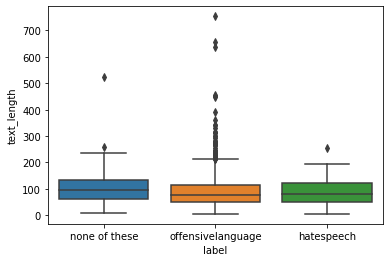

In [51]:
sns.boxplot(x='label', y='text_length', data=f2)

In [52]:
f21=f2.text

In [53]:
stopwords = nltk.corpus.stopwords.words("english")
#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()
def preprocess(text):

 # removal of extra spaces
 regex_pat = re.compile(r'\s+')
 text_space = text.str.replace(regex_pat, ' ')
 # removal of @name[mention]
 regex_pat = re.compile(r'@[\w\-]+')
 text_name = text_space.str.replace(regex_pat, '')
 # removal of links[https://abc.com]
 giant_url_regex = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
 '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
 texts = text_name.str.replace(giant_url_regex, '')

 # removal of punctuations and numbers
 punc_remove = texts.str.replace("[^a-zA-Z]", " ")
 # remove whitespace with a single space
 newtext=punc_remove.str.replace(r'\s+', ' ')
 # remove leading and trailing whitespace
 newtext=newtext.str.replace(r'^\s+|\s+?$','')
 # replace normal numbers with numbr
 newtext=newtext.str.replace(r'\d+(\.\d+)?','numbr')
 # removal of capitalization
 text_lower = newtext.str.lower()

 # tokenizing
 tokenized_text = text_lower.apply(lambda x: x.split())

 # removal of stopwords
 tokenized_text= tokenized_text.apply(lambda x: [item for item in x if item not in stopwords])
 tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x])

 for i in range(len(tokenized_text)):
   tokenized_text[i] = ' '.join(tokenized_text[i])
   text_p= tokenized_text

 return text_p
processed_texts = preprocess(f21)
f2['processed_texts'] = processed_texts
print(f2[["text","processed_texts"]].head(10))

                                                text                                    processed_texts
0  !!! RT @mayasolovely: As a woman you shouldn't...  woman complain clean hous amp man alway take t...
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  boy dat cold tyga dwn bad cuffin dat hoe st place
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...         dawg ever fuck bitch start cri confus shit
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...                                   look like tranni
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     shit hear might true might faker bitch told ya
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...      shit blow claim faith somebodi still fuck hoe
6  !!!!!!"@__BrighterDays: I can not just sit up ...              sit hate anoth bitch got much shit go
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...            caus tire big bitch come us skinni girl
8  " &amp; you might not get ya bitch back &amp; ...            

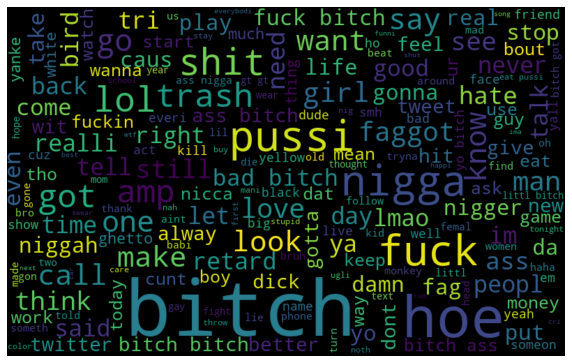

In [54]:
from wordcloud import WordCloud
all_words = ' '.join([text for text in f2['processed_texts'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

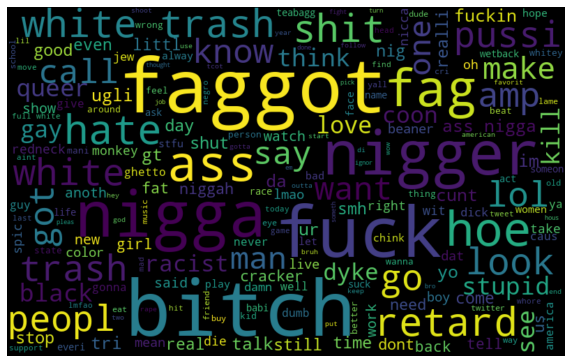

In [55]:
hatred_words = ' '.join([text for text in f2['processed_texts'][f2['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

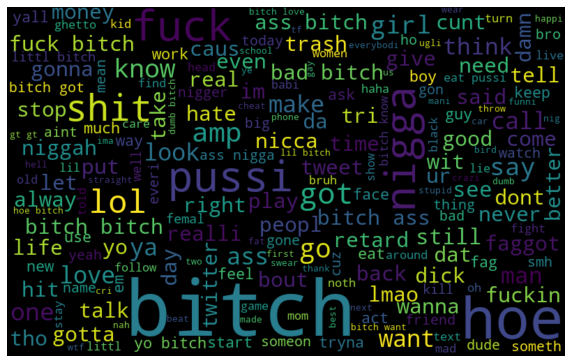

In [56]:
offensive_words = ' '.join([text for text in f2['processed_texts'][f2['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [57]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [58]:
sentiment_analyzer = VS()
def count_tags(text_c):
  space_pattern = '\s+'
  giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
 '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  mention_regex = '@[\w\-]+'
  hashtag_regex = '#[\w\-]+'
  parsed_text = re.sub(space_pattern, ' ', text_c)
  parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
  parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
  parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
  return (parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(text):
  sentiment = sentiment_analyzer.polarity_scores(text)
  twitter_objs = count_tags(text)
  features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],twitter_objs[2]]
  return features

def sentiment_analysis_array(texts):
  features=[]
  for t in texts:
    features.append(sentiment_analysis(t))
  return np.array(features)
final_features = sentiment_analysis_array(f21)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [59]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVe
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(f2['processed_texts'] )
tfidf


<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

In [60]:
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 6448)

In [61]:
X1 = tfidf
y1 = f2['class'].astype(int)
X_train_tfidf1, X_test_tfidf1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, test_size=0.2)
model1 = LogisticRegression().fit(X_train_tfidf1,y_train1)
y_preds1 = model1.predict(X_test_tfidf1)
report1 = classification_report( y_test1, y_preds1 )
print(report1)
acc1=accuracy_score(y_test1,y_preds1)
print("Logistic Regression, Accuracy Score:" , acc1)


              precision    recall  f1-score   support

           0       0.56      0.18      0.27       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.84      0.85       835

    accuracy                           0.90      4957
   macro avg       0.77      0.66      0.68      4957
weighted avg       0.88      0.90      0.88      4957

Logistic Regression, Accuracy Score: 0.8975186604801291


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [62]:
X1 = pd.DataFrame(modelling_features)
y1 = f2['class'].astype(int)
X_train_tfidf1, X_test_tfidf1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42, test_size=0.2)
model1 = LogisticRegression().fit(X_train_tfidf1,y_train1)
y_preds1 = model1.predict(X_test_tfidf1)
report1 = classification_report( y_test1, y_preds1 )
print(report1)
acc1=accuracy_score(y_test1,y_preds1)
print("Logistic Regression, Accuracy Score:" , acc1)


              precision    recall  f1-score   support

           0       0.59      0.19      0.28       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.86      0.85       835

    accuracy                           0.90      4957
   macro avg       0.78      0.67      0.69      4957
weighted avg       0.89      0.90      0.89      4957

Logistic Regression, Accuracy Score: 0.900342949364535


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [63]:
X = pd.DataFrame(modelling_features)
y = f2['class'].astype(int)
X_train_bow12, X_test_bow12, y_train12, y_test12 = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow12,y_train12)
y_preds12 = rf.predict(X_test_bow12)
acc12=accuracy_score(y_test12,y_preds12)
report2 = classification_report( y_test12, y_preds12 )
print(report2)
print("Random Forest, Accuracy Score:",acc12)

              precision    recall  f1-score   support

           0       0.51      0.13      0.20       290
           1       0.91      0.96      0.94      3832
           2       0.84      0.83      0.84       835

    accuracy                           0.89      4957
   macro avg       0.75      0.64      0.66      4957
weighted avg       0.88      0.89      0.88      4957

Random Forest, Accuracy Score: 0.8928787573128909


In [64]:
X = pd.DataFrame(modelling_features)
y = f2['class'].astype(int)
X_train_bow13, X_test_bow13, y_train13, y_test13 = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_bow13,y_train13)
y_preds13 = nb.predict(X_test_bow13)
acc23=accuracy_score(y_test13,y_preds13)
report13 = classification_report( y_test13, y_preds13 )
print(report13)
print("Naive Bayes, Accuracy Score:",acc23)

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.59      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.650191648174299


In [65]:
X = pd.DataFrame(modelling_features)
y = f2['class'].astype(int)
X_train_bow14, X_test_bow14, y_train14, y_test14 = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow14,y_train14)
y_preds14 = support.predict(X_test_bow14)
acc34=accuracy_score(y_test14,y_preds14)
report14 = classification_report( y_test14, y_preds14 )
print(report14)
print("SVM, Accuracy Score:" , acc34)

              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.74      0.69      0.70      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.891466612870688


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


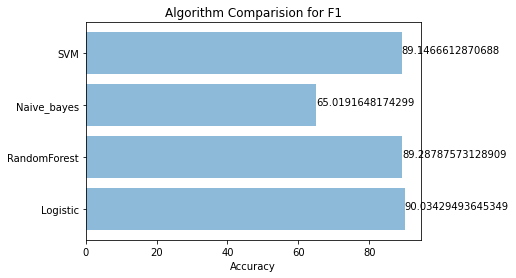

In [66]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
acc1=acc1*100
acc12=acc12*100
acc23=acc23*100
acc34=acc34*100
performance = [acc1,acc12,acc23,acc34]
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Accuracy')
plt.title('Algorithm Comparision for F1')
for index, value in enumerate(performance):
 plt. text(value, index, str(value))
plt.show()

In [67]:
with open('/content/drive/My Drive/PROJECT/bw.txt') as f:
 list1=[word for line in f for word in line.split()]

In [68]:
X = tfidf
y = f2['class'].astype(int)

In [69]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.47      0.15      0.23       290
           1       0.93      0.96      0.94      3832
           2       0.83      0.90      0.86       835

    accuracy                           0.90      4957
   macro avg       0.74      0.67      0.68      4957
weighted avg       0.88      0.90      0.89      4957

Random Forest, Accuracy Score: 0.9007464192051644


In [96]:
def func_mm(text):
  hh=text
  cleaned_sentence = []
  sentence = removeURL(text)
  sentence = removeHTML(sentence)
  sentence = onlyAlphabets(sentence)
  sentence = sentence.lower()
  for word in sentence.split():
    if word not in stop:
      stemmed = sno.stem(word)
      cleaned_sentence.append(stemmed)
  #print(cleaned_sentence)
  ff2 = sentiment_analysis_array(cleaned_sentence)
  nf2 = pd.DataFrame({'Neg':ff2[:,0],'Pos':ff2[:,1],'Neu':ff2[:,2],'Compound':ff2[:,3],'url_tag':ff2[:,4],'mention_tag':ff2[:,5],'hash_tag':ff2[:,6]})
  nf2
  yt=pd.DataFrame(nf2)
  tt2 = tfidf_vectorizer.transform(cleaned_sentence)
  tt2a = tt2.toarray()
  op = rf.predict(tt2)
  """
  b=0
  print("Hate content:")
  for i in op:
    if (i==0) or (i==1):
      print("Yes")
      b=1
  if(b==0):
    print("No")
  """
  txt=text.split()
  res=hh
  for w in txt:
    if w in list1:
      l=len(w)
      r2='*'*l
      res=text.replace(w,r2)
      text=res
  print("After cleaning:")
  print(res)
  mm="Yes"
  ip=input("Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.")
  if ip.lower() == mm.lower():
    twitter.update_status(status=res)
  print("Work Done!!")

In [95]:
text="ABTUP movie is not good as her religion is Z classmate"
print(text)
func_mm(text)

ABTUP movie is not good as her religion is Z classmate
religion
After cleaning:
ABTUP movie is not good as her ******** is Z classmate
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.no
Work Done!!


In [97]:
from twython import Twython
consumer_key        = 'Dcg3USX0cvXEgsrzhsu8QAjeG'
consumer_secret     = 'HutJoyFrVhhrwyYPeLSn1BMgJeM4bjL7iTKSU4AuwiF3y70LpP'
access_token        = '1381947521660899338-PZP8mFSqFS8an8YdJFgIfoncx6xLYR'
access_token_secret = 'WjNP6Qpte2cHtTwuQZgQGTqmoGX7KYuqpuTC3YcgR4iUM'

twitter = Twython(
    consumer_key,
    consumer_secret,
    access_token,
    access_token_secret
)


In [98]:
def sa_mm_nn(a):
  audio=a
  with sr.AudioFile(audio) as source:
    audio = r.record(source)
  try:
    text = r.recognize_google(audio)
  except Exception as e:
    print (e)
  print(text)
  ht=text
  #text=a #forwithout conversion
  cleaned_sentence = []
  sentence = removeURL(text) 
  sentence = removeHTML(sentence)
  sentence = onlyAlphabets(sentence) 
  sentence = sentence.lower()    
  for word in sentence.split():
    if word not in stop:
      stemmed = sno.stem(word)
      cleaned_sentence.append(stemmed)
  instance = tokenizer.texts_to_sequences(cleaned_sentence)
  flat_list = []
  for sublist in instance:
    for item in sublist:
      flat_list.append(item)
  flat_list = [flat_list]
  instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
  x=model.predict(instance)
  print(x)
  if x<0.4:
    print("Negative")
  elif x>0.65:
    print("Positive")
  else:
    print("Neutral")
  func_mm(ht)

In [99]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_1.wav')


hello I saw a movie recently and it was a good one and it was a thriller movie that's why I like it very much
[[0.67399937]]
Positive
After cleaning:
hello I saw a movie recently and it was a good one and it was a thriller movie that's why I like it very much
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [100]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_2.wav')


no tea flavor at all just whole branch of artificial flavors it is not rat unable I wasted twenty bucks
[[0.07723433]]
Negative
After cleaning:
no tea flavor at all just whole branch of artificial flavors it is not rat unable I wasted twenty bucks
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [101]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_3.wav')


classmate movie is not good as their religion is ABC
[[0.14582765]]
Negative
After cleaning:
classmate movie is not good as their ******** is ABC
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [102]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_4.wav')


arrived in 6 days and was so stale I could not eat any of the six bags
[[0.11846882]]
Negative
After cleaning:
arrived in 6 days and was so stale I could not eat any of the six bags
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [103]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_5.wav')



the munchkin fresh food feeder is an okay product it's kind of like sucking on food while my daughter was interested in it for a little while I lost interest
[[0.29373968]]
Negative
After cleaning:
the munchkin fresh food feeder is an okay product it's kind of like ******* on food while my daughter was interested in it for a little while I lost interest
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [104]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_6.wav')


I love this movie
[[0.98118925]]
Positive
After cleaning:
I love this movie
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [105]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_7.wav')


I received the items in a timely manner upon receipt I removed the Pop-Tart was stale and left an awful taste in my mouth
[[0.03693539]]
Negative
After cleaning:
I received the items in a timely manner upon receipt I removed the Pop-Tart was stale and left an awful taste in my mouth
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [106]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_8.wav')


I wouldn't even think of buying this product unless I know the price per unit how can I compare the writings online or in a store
[[0.43872458]]
Neutral
After cleaning:
I wouldn't even think of buying this product unless I know the price per unit how can I compare the writings online or in a store
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [107]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_9.wav')


this candy is not as described the middle is almost hard it is not a silky or smooth feeling as described looks and tastes like it's way past its expiration date never recommend us paid a good chunk of cash for nothing
[[0.11733657]]
Negative
After cleaning:
this candy is not as described the middle is almost hard it is not a silky or smooth feeling as described looks and tastes like it's way past its expiration date never recommend us paid a good chunk of cash for nothing
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!


In [108]:
sa_mm_nn('/content/drive/My Drive/PROJECT/audio_10.wav')


I love these Wintergreen Altoids smalls so much I had to the packaging is small for convenience and the Altoids are smaller
[[0.8191824]]
Positive
After cleaning:
I love these Wintergreen Altoids smalls so much I had to the packaging is small for convenience and the Altoids are smaller
Do you want to print in Twitter application? Enter Yes if u want to. else it will be taken as No.yes
Work Done!!
